# Libraries & Train data

In this notebook, we will display time series EDA for products which have the most clicks/carts/orders.
We will use RAPIDS cuDF to process dataframes and seaborn to display EDA.



In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns
import cudf, cupy
print('Using RAPIDS version',cudf.__version__)

Using RAPIDS version 21.10.01


## Loading the Train Data

In [2]:
%%time
train = cudf.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')

CPU times: user 1.67 s, sys: 1.34 s, total: 3.02 s
Wall time: 25.7 s


In [3]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [6]:
id2type, type2id = ['clicks', 'carts', 'orders'], {'clicks': 0, 'carts': 1, 'orders': 2}

In [7]:
id2type, type2id

(['clicks', 'carts', 'orders'], {'clicks': 0, 'carts': 1, 'orders': 2})

In [10]:
%%time
train.ts = cudf.to_datetime((train.ts + 2*60*60) * 1e9)
print('Train min date and max date are:', train.ts.min(),'and', train.ts.max())

Train min date and max date are: 2022-08-01T00:00:00.000000000 and 2022-08-28T23:59:59.000000000
CPU times: user 43.7 ms, sys: 32.1 ms, total: 75.8 ms
Wall time: 86.7 ms


In [11]:
train["dayofyear"] = (train.ts.dt.dayofyear).astype(np.int16)
train["weekofyear"] = ((train["dayofyear"]-3)//7).astype(np.int8)
train.head()


,session,aid,ts,type,dayofyear,weekofyear
0,0,1517085,2022-08-01 00:00:00,0,213,30
1,0,1563459,2022-08-01 00:01:44,0,213,30
2,0,1309446,2022-08-01 17:23:59,0,213,30
3,0,16246,2022-08-01 17:28:39,0,213,30
4,0,1781822,2022-08-01 17:31:11,0,213,30


In [80]:
groupby_type = train.groupby(['type'])["aid"].count().reset_index()
groupby_type = groupby_type.to_pandas()
groupby_type.head()

,type,aid
0,1,16896191
1,0,194720954
2,2,5098951


<AxesSubplot:xlabel='type', ylabel='aid'>

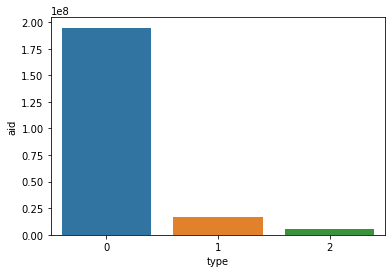

In [74]:

sns.barplot(data=groupby_type, x="type", y="aid")

In [44]:
train_temp = train
train_temp["weekday"] = (train.ts.dt.weekday)
# train_temp = train_temp.loc[(train_temp["weekday"] == 3)]
train_temp.head()

,session,aid,ts,type,dayofyear,weekofyear,weekday
0,0,1517085,2022-08-01 00:00:00,0,213,30,0
1,0,1563459,2022-08-01 00:01:44,0,213,30,0
2,0,1309446,2022-08-01 17:23:59,0,213,30,0
3,0,16246,2022-08-01 17:28:39,0,213,30,0
4,0,1781822,2022-08-01 17:31:11,0,213,30,0


In [45]:

groupby_type_and_day_of_week = train_temp.groupby(['type','weekofyear', 'weekday'])["aid"].count().reset_index()
groupby_type_and_day_of_week.head()

,type,weekofyear,weekday,aid
0,0,32,2,7035817
1,2,31,1,271399
2,2,33,2,154910
3,1,31,1,687532
4,2,32,1,182427


In [46]:
%%time
click_count_by_day_of_week = groupby_type_and_day_of_week.loc[(groupby_type_and_day_of_week["type"] == 0)]
click_count_by_day_of_week = click_count_by_day_of_week.to_pandas()
click_count_by_day_of_week.head()
                                                              

CPU times: user 6.7 ms, sys: 2.88 ms, total: 9.57 ms
Wall time: 9.21 ms


,type,weekofyear,weekday,aid
0,0,32,2,7035817
5,0,32,5,6945666
6,0,30,1,6768898
7,0,31,3,6564234
9,0,32,6,8224583


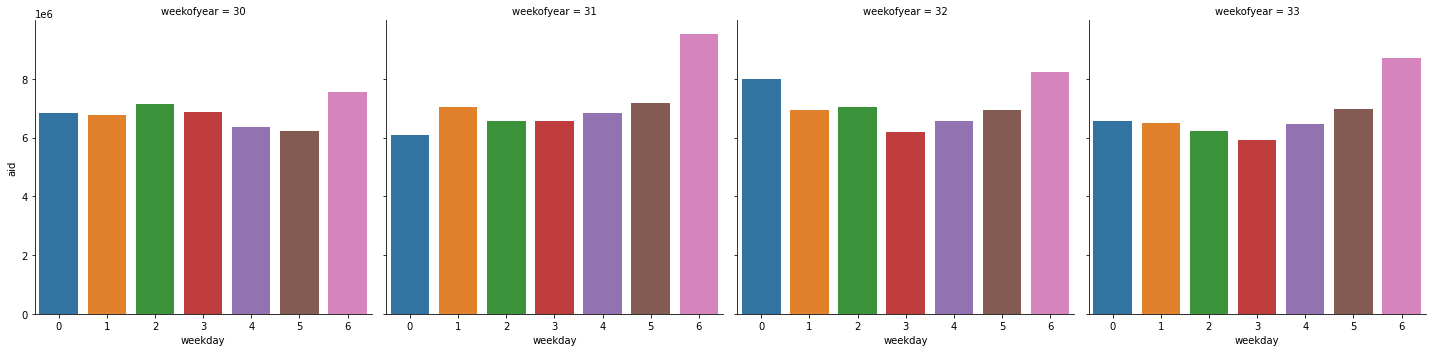

In [47]:
g= sns.catplot(
    data=click_count_by_day_of_week,
    x='weekday',
    y='aid',
    col='weekofyear',
    kind='bar',
)


In [48]:
%%time
cart_count_by_day_of_week = groupby_type_and_day_of_week.loc[(groupby_type_and_day_of_week["type"] == 1)]
cart_count_by_day_of_week = cart_count_by_day_of_week.to_pandas()
cart_count_by_day_of_week.head()

CPU times: user 8.92 ms, sys: 112 µs, total: 9.04 ms
Wall time: 9.82 ms


,type,weekofyear,weekday,aid
3,1,31,1,687532
10,1,33,4,589977
15,1,31,6,783262
16,1,30,1,567872
17,1,31,4,571376


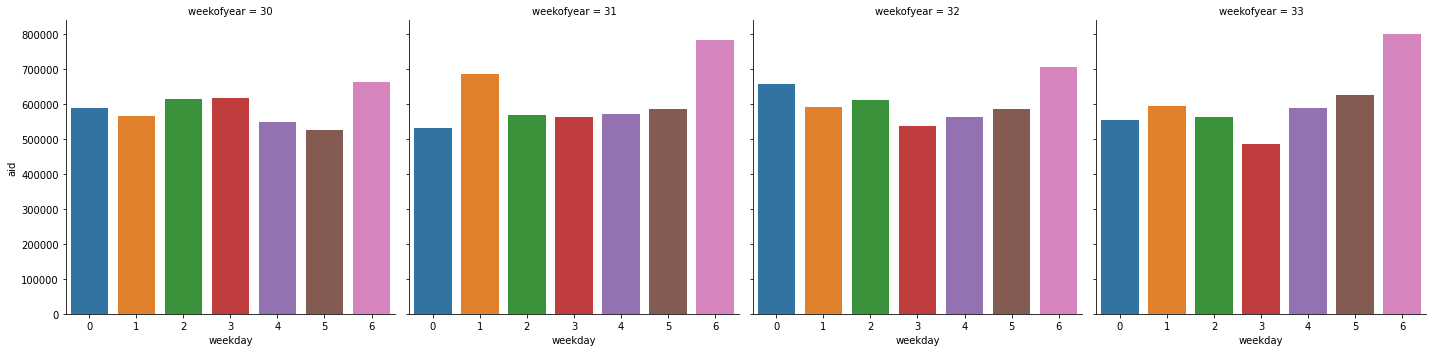

In [49]:
g= sns.catplot(
    data=cart_count_by_day_of_week,
    x='weekday',
    y='aid',
    col='weekofyear',
    kind='bar',
)


In [50]:
%%time
order_count_by_day_of_week = groupby_type_and_day_of_week.loc[(groupby_type_and_day_of_week["type"] == 2)]
order_count_by_day_of_week = order_count_by_day_of_week.to_pandas()
order_count_by_day_of_week.head()

CPU times: user 8.22 ms, sys: 0 ns, total: 8.22 ms
Wall time: 7.42 ms


,type,weekofyear,weekday,aid
1,2,31,1,271399
2,2,33,2,154910
4,2,32,1,182427
8,2,33,3,139518
11,2,32,5,165842


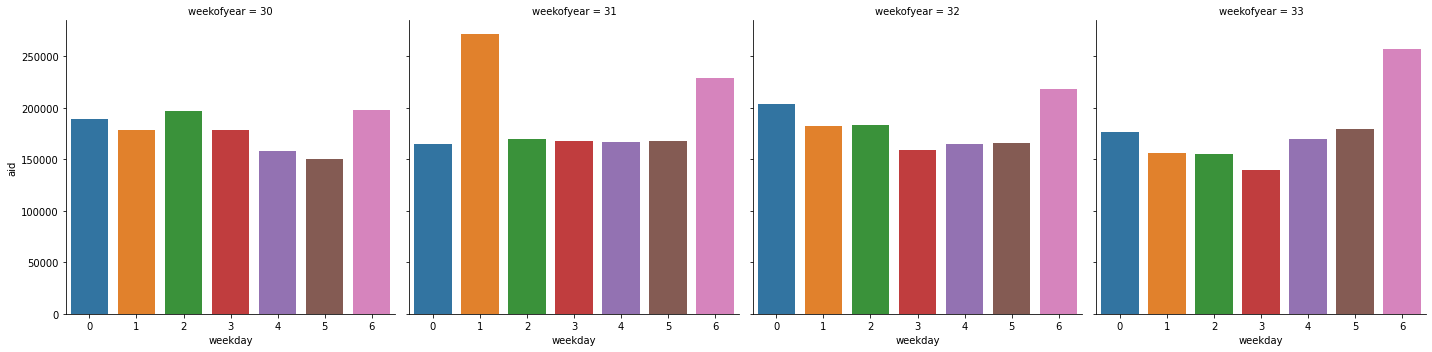

In [51]:
g= sns.catplot(
    data=order_count_by_day_of_week,
    x='weekday',
    y='aid',
    col='weekofyear',
    kind='bar',
)


In [53]:
del click_count_by_day_of_week
del cart_count_by_day_of_week
del order_count_by_day_of_week
del groupby_type_and_day_of_week
del train_temp

NameError: name 'click_count_by_day_of_week' is not defined

In [57]:
train_temp = train
train_temp["hour"] = (train.ts.dt.hour)
# train_temp = train_temp.loc[(train_temp["weekday"] == 3)]
train_temp.head()

,session,aid,ts,type,dayofyear,weekofyear,weekday,hour
0,0,1517085,2022-08-01 00:00:00,0,213,30,0,0
1,0,1563459,2022-08-01 00:01:44,0,213,30,0,0
2,0,1309446,2022-08-01 17:23:59,0,213,30,0,17
3,0,16246,2022-08-01 17:28:39,0,213,30,0,17
4,0,1781822,2022-08-01 17:31:11,0,213,30,0,17


In [59]:
groupby_type_and_hour = train_temp.groupby(['type', 'hour'])["aid"].count().reset_index()


In [60]:
%%time
click_count_by_hour = groupby_type_and_hour.loc[(groupby_type_and_hour["type"] == 0)]
click_count_by_hour = click_count_by_hour.to_pandas()
click_count_by_hour.head()
                                                              

CPU times: user 7.09 ms, sys: 1.9 ms, total: 9 ms
Wall time: 8.3 ms


,type,hour,aid
0,0,14,10937098
5,0,5,1393322
7,0,19,12913220
11,0,2,1576860
12,0,0,5134353


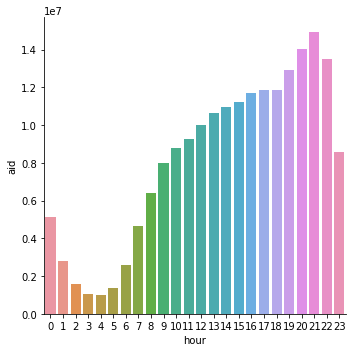

In [62]:
g= sns.catplot(
    data=click_count_by_hour,
    x='hour',
    y='aid',
    kind='bar',
)

In [64]:
%%time
cart_count_by_hour = groupby_type_and_hour.loc[(groupby_type_and_hour["type"] == 1)]
cart_count_by_hour = cart_count_by_hour.to_pandas()
cart_count_by_hour.head()

CPU times: user 8.16 ms, sys: 0 ns, total: 8.16 ms
Wall time: 7.58 ms


,type,hour,aid
3,1,18,1026187
4,1,3,78410
6,1,4,73652
8,1,22,1067267
9,1,15,989996


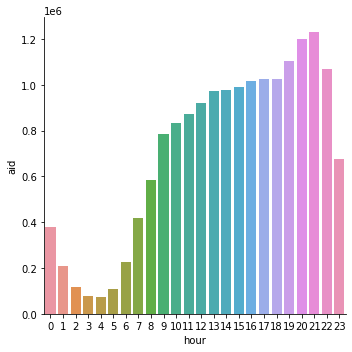

In [65]:
g= sns.catplot(
    data=cart_count_by_hour,
    x='hour',
    y='aid',
    kind='bar',
)

In [66]:
%%time
order_count_by_hour = groupby_type_and_hour.loc[(groupby_type_and_hour["type"] == 2)]
order_count_by_hour = order_count_by_hour.to_pandas()
order_count_by_hour.head()

CPU times: user 7.46 ms, sys: 1.31 ms, total: 8.77 ms
Wall time: 7.67 ms


,type,hour,aid
1,2,22,315325
2,2,7,119545
10,2,2,24663
13,2,21,375037
16,2,3,16281


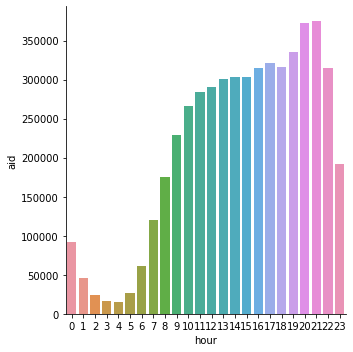

In [67]:
g= sns.catplot(
    data=order_count_by_hour,
    x='hour',
    y='aid',
    kind='bar',
)

In [68]:
del order_count_by_hour
del cart_count_by_hour
del click_count_by_hour
del groupby_type_and_hour
del train_temp

In [13]:
train["weekofyear"].value_counts()

32    55407112
31    55387191
30    53160878
33    52760915
Name: weekofyear, dtype: int32

In [12]:
train["weekofyear"].value_counts()

32    55407112
31    55387191
30    53160878
33    52760915
Name: weekofyear, dtype: int32

# Session with AID by week and type

Number of sessions a particular AID was present by week and action type

In [14]:
%%time
aid_per_week = train.groupby(["aid", "weekofyear", "type"])["session"].count().reset_index()
aid_per_week.head()

CPU times: user 299 ms, sys: 51.6 ms, total: 350 ms
Wall time: 349 ms


,aid,weekofyear,type,session
0,592716,30,0,4
1,1821653,33,0,3
2,1829700,30,0,2
3,1824708,33,1,3
4,1421989,31,0,11


### the first AID : AID 592716 during week 30 with type - 0(clicks) appears 4 times.

# Session with AID by day and type

Number of sessions a particular AID was present by day of year and action type

In [15]:
%%time
aid_per_day = train.groupby(["aid", "dayofyear", 'type'])["session"].count().reset_index()
aid_per_day.head()

CPU times: user 341 ms, sys: 54.1 ms, total: 395 ms
Wall time: 400 ms


,aid,dayofyear,type,session
0,1325666,221,0,8
1,1330684,215,0,65
2,1262874,215,0,2
3,1239660,213,1,1
4,1474613,237,0,4


## The 20 most important AIDS by week and by type

In [23]:
%%time
most_aid_per_week = {}
for week in aid_per_week["weekofyear"].unique().values.tolist():
    most_aid_per_week[week]={}
    for type_t in [0, 1, 2]: # 0 : click / 1 : Cart / 2 : Order
        most_aid_per_week[week][type_t] = aid_per_week.loc[(aid_per_week["type"] == type_t)&(aid_per_week["weekofyear"]==week)].sort_values("session", ascending=False)[:20]["aid"].values.tolist()

CPU times: user 90.6 ms, sys: 60 ms, total: 151 ms
Wall time: 155 ms


In [24]:
import json
print(json.dumps(most_aid_per_week,sort_keys=True, indent=4))

{
    "30": {
        "0": [
            1083665,
            1460571,
            29735,
            670006,
            1502122,
            108125,
            1733943,
            610733,
            832192,
            95488,
            756588,
            1743151,
            231487,
            803544,
            152547,
            554660,
            1294924,
            1236775,
            322370,
            1615582
        ],
        "1": [
            152547,
            33343,
            1562705,
            1083665,
            231487,
            1733943,
            166037,
            29735,
            832192,
            1022566,
            1743151,
            670006,
            1629608,
            80222,
            756588,
            1825743,
            322370,
            77440,
            1502122,
            1498443
        ],
        "2": [
            231487,
            1083665,
            80222,
            1629608,
            1733943,
        